In [1]:
# 使jupyter能够交互式显示图像
%matplotlib notebook

import json
import datetime

import pandas as pd
from numpy import array
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.font_manager as fm
from matplotlib.pyplot import MultipleLocator
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql import *
from pyspark.sql.functions import split, explode, concat, concat_ws
from pyspark.sql.functions import lit
import matplotlib.font_manager as fm
from pyspark.sql.types import *

my_font=fm.FontProperties(fname="/Users/ppx/Desktop/中文字体/simsun.ttf")

In [2]:
# 加载 LEWTEB144HE103899 数据
data=spark.read.json("hdfs://cdh1:8020/user/hbase/pro_dfjk4new/fault_data/2018-08-08/")
data.collect()


[Row(battery_cell_consistency_low_alert='False', battery_cell_voltage_highest_value='3.32', battery_cell_voltage_lowest_value='3.31', battery_fault_codes='[]', battery_faults_count='0', battery_high_temperature_alert='False', braking_system_alert='False', charge_status='\\xE6\\x9C\\xAA\\xE5\\x85\\x85\\xE7\\x94\\xB5', current='8.7', dc_dc_status_alert='False', dc_dc_temperature_alert='False', energy_storage_device_high_voltage_alert='False', energy_storage_device_low_voltage_alert='False', energy_storage_device_over_charge_alert='False', has_alert='false', highest_alert_level='\\xE6\\x97\\xA0\\xE6\\x95\\x85\\xE9\\x9A\\x9C', hvil_alert='False', insulation_alert='False', maximum_temperature_value='35', minimum_temperature_value='33', motor_controller_temperature_alert='False', motor_temperature_alert='False', obd_time='2018-08-08 00:04:18', rechargeable_energy_storage_system_mismatch_alert='False', resd_subsystem_count='1', resd_subsystem_temperature_list="[{'subsystem_probe_temperature_l

In [3]:
# 使用 pyspark合并

# 提取 resd_subsystem_voltage_list 列表的数据转为列
resd_subsystem_voltage_list11=data.select("resd_subsystem_voltage_list").rdd.map(lambda x:(eval(x[0])[0])).toDF()
# resd_subsystem_voltage_list11.show(5)


# 添加索引
# resd_subsystem_voltage_list12=resd_subsystem_voltage_list.withColumn("id1",monotonically_increasing_id())
# resd_subsystem_voltage_list12.show(5)

resd_subsystem_voltage_list12=resd_subsystem_voltage_list11.toPandas()
resd_subsystem_voltage_list12.insert(0,"index1",resd_subsystem_voltage_list12.index)
resd_subsystem_voltage_list13=spark.createDataFrame(resd_subsystem_voltage_list12)
resd_subsystem_voltage_list13.show(5)

# 提取电池列表列,将每个电池转为列
# 注:dataframe 的变量是覆盖式，变量可重复用
battery_cell_voltage_list11=resd_subsystem_voltage_list.select(resd_subsystem_voltage_list.battery_cell_voltage_list)\
                          .rdd.map(lambda x:x[0]).toDF()
battery_cell_voltage_list11.show(2)

# 添加索引
# battery_cell_voltage_list12=battery_cell_voltage_list.withColumn("id2",monotonically_increasing_id())
# battery_cell_voltage_list12.show(2)

battery_cell_voltage_list12=battery_cell_voltage_list11.toPandas()
battery_cell_voltage_list12.insert(0,"index2",battery_cell_voltage_list12.index)
battery_cell_voltage_list13=spark.createDataFrame(battery_cell_voltage_list12)
battery_cell_voltage_list13.show(2)

# 使用 spark 合并表
resd_subsystem_voltage_list14=resd_subsystem_voltage_list13.join(battery_cell_voltage_list13,\
                              resd_subsystem_voltage_list13.index1==battery_cell_voltage_list13.index2,how="outer")
resd_subsystem_voltage_list14.show(2)
type(resd_subsystem_voltage_list)


/Users/ppx/workspace/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+------+------------------+-------------------------+-----------------+----------------+-----------------+
|index1|battery_cell_count|battery_cell_voltage_list|subsystem_current|subsystem_number|subsystem_voltage|
+------+------------------+-------------------------+-----------------+----------------+-----------------+
|     0|               164|     [3.32, 3.31, 3.32...|              8.7|               1|            543.8|
|     1|               164|     [3.31, 3.31, 3.31...|             20.4|               1|            543.2|
|     2|               164|     [3.32, 3.31, 3.32...|             13.5|               1|            543.6|
|     3|               164|     [3.31, 3.31, 3.31...|             20.7|               1|            542.4|
|     4|               164|     [3.3, 3.29, 3.3, ...|             32.5|               1|            541.9|
+------+------------------+-------------------------+-----------------+----------------+-----------------+
only showing top 5 rows



NameError: name 'resd_subsystem_voltage_list' is not defined

In [16]:
# 使用 pandas 合并

# 提取 resd_subsystem_voltage_list 列表的数据转为列
resd_subsystem_voltage_list11=data.select("resd_subsystem_voltage_list").rdd.map(lambda x:(eval(x[0])[0])).toDF()
# resd_subsystem_voltage_list11.show(5)

# 使用 pandas 设置索引
pdf=resd_subsystem_voltage_list11.toPandas()
pdf.insert(0,"index1",pdf.index)


battery_cell_voltage_list11=resd_subsystem_voltage_list11.select(resd_subsystem_voltage_list11.battery_cell_voltage_list)\
                            .rdd.map(lambda x:x[0]).toDF()
battery_cell_voltage_list11.show(2)

pdf1=battery_cell_voltage_list11.toPandas()
pdf1.insert(0,"index2",pdf1.index)

# 合并 resd_subsystem_voltage_list 表
# pdf.merge(pdf1)
resd_subsystem_voltage_list=pdf.join(pdf1,how="inner")
resd_subsystem_voltage_list
resd_subsystem_voltage_list=pd.concat([pdf,pdf1],axis=1,join="inner")
# resd_subsystem_voltage_list

# 合并全表

pdf3=data.toPandas()
pdf3.insert(0,"index",pdf3.index)

data21=pdf3.join(resd_subsystem_voltage_list,how="inner")
data21=pd.concat([pdf3,resd_subsystem_voltage_list],axis=1,join="inner")
data21
data22=spark.createDataFrame(data21)
data22.show()

/Users/ppx/workspace/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  _1|  _2|  _3|  _4|  _5|  _6|  _7|  _8|  _9| _10| _11| _12| _13| _14| _15| _16| _17| _18| _19| _20| _21| _22| _23| _24| _25| _26| _27| _28| _29| _30| _31| _32| _33| _34| _35| _

,index1,battery_cell_count,battery_cell_voltage_list,subsystem_current,subsystem_number,subsystem_voltage,index2,_1,_2,_3,...,_155,_156,_157,_158,_159,_160,_161,_162,_163,_164
0,0,164,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",8.7,1,543.8,0,3.32,3.31,3.32,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
1,1,164,"[3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.3...",20.4,1,543.2,1,3.31,3.31,3.31,...,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
2,2,164,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",13.5,1,543.6,2,3.32,3.31,3.32,...,3.31,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
3,3,164,"[3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.3...",20.7,1,542.4,3,3.31,3.31,3.31,...,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
4,4,164,"[3.3, 3.29, 3.3, 3.29, 3.3, 3.29, 3.3, 3.29, 3...",32.5,1,541.9,4,3.30,3.29,3.30,...,3.30,3.29,3.30,3.29,3.30,3.29,3.30,3.29,3.30,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,281,164,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",6.1,1,543.5,281,3.32,3.31,3.32,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
282,282,164,"[3.31, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",5.4,1,543.5,282,3.31,3.31,3.32,...,3.32,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
283,283,164,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",4.9,1,543.6,283,3.32,3.31,3.32,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
284,284,164,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3...",3.5,1,543.6,284,3.32,3.31,3.32,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31


,index,battery_cell_consistency_low_alert,battery_cell_voltage_highest_value,battery_cell_voltage_lowest_value,battery_fault_codes,battery_faults_count,battery_high_temperature_alert,braking_system_alert,charge_status,current,...,_155,_156,_157,_158,_159,_160,_161,_162,_163,_164
0,0,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,8.7,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
1,1,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,20.4,...,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
2,2,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,13.5,...,3.31,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
3,3,False,3.31,3.3,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,20.7,...,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
4,4,False,3.32,3.29,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,32.5,...,3.30,3.29,3.30,3.29,3.30,3.29,3.30,3.29,3.30,3.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,281,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,6.1,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
282,282,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,5.4,...,3.32,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31,3.31
283,283,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,4.9,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31
284,284,False,3.32,3.31,[],0,False,False,\xE6\x9C\xAA\xE5\x85\x85\xE7\x94\xB5,3.5,...,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31,3.32,3.31


+-----+----------------------------------+----------------------------------+---------------------------------+-------------------+--------------------+------------------------------+--------------------+--------------------+-------+------------------+-----------------------+----------------------------------------+---------------------------------------+---------------------------------------+---------+--------------------+----------+----------------+-------------------------+-------------------------+----------------------------------+-----------------------+-------------------+-------------------------------------------------+--------------------+-------------------------------+---------------------------+---------------------------------+--------------------------------+-----------------+-------------+------------------+----------------------------+-------+-----------------+------+------------------+-------------------------+-----------------+----------------+-----------------+----

In [5]:
# 电池列表分析

# 单个电池电压与总电压呈正相关
resd_subsystem_voltage_list.corr("subsystem_voltage","_1")
resd_subsystem_voltage_list.corr("subsystem_voltage","_164")
resd_subsystem_voltage_list.corr("subsystem_voltage","_90")

# 电池组电压与电流呈负相关
resd_subsystem_voltage_list.corr("subsystem_voltage","subsystem_current")

# 单个电池电压与电流关系，负相关
resd_subsystem_voltage_list.corr("subsystem_current","_17")
resd_subsystem_voltage_list.corr("subsystem_current","_51")
resd_subsystem_voltage_list.corr("subsystem_current","_121")


# 计算电池组电压总和
# 提出电池组，collectk是列表类型,show()是列类型
rd=resd_subsystem_voltage_list.select(resd_subsystem_voltage_list.battery_cell_voltage_list)\
    .rdd.map(lambda x:x[0]).collect()
# print(rd)

list1=[]
list2=[]

# 对列表元素做操作
for x in rd:
    # 对列表元素求和
    list1.append(sum(x))   
# list1

# 将list转为df类型，当df无法推荐类型时，就给他指定类型
df=sqlContext.createDataFrame(list1,FloatType())
# 重命名列名，
df1=df.withColumnRenamed("value","battery_cell_voltage_list_sum")
# 添加索引
battery_cell_voltage_list_sum=df1.withColumn("id3",monotonically_increasing_id())

# 合并列到表
resd_subsystem_voltage_list=resd_subsystem_voltage_list1.join(battery_cell_voltage_list_sum,\
                                    resd_subsystem_voltage_list1.id1==battery_cell_voltage_list_sum.id3).drop("id3")
resd_subsystem_voltage_list.show(1)


ValueError: method must be either 'pearson', 'spearman', 'kendall', or a callable, 'subsystem_voltage' was supplied

In [6]:
# 总电压与相关性

# 1.转化数据类型
data11=data.select(data.voltage.astype("float"),data.current.astype("float"),data.maximum_temperature_value.astype("float"),data.minimum_temperature_value.astype("float"))
data11.show()

# 2.计算相关系数
data11.corr("voltage","current")
data11.corr("voltage","maximum_temperature_value")
data11.corr("current","maximum_temperature_value")
data11.corr("voltage","minimum_temperature_value")
data11.corr("current","minimum_temperature_value")

+-------+-------+-------------------------+-------------------------+
|voltage|current|maximum_temperature_value|minimum_temperature_value|
+-------+-------+-------------------------+-------------------------+
|  543.8|    8.7|                     35.0|                     33.0|
|  543.2|   20.4|                     35.0|                     33.0|
|  543.6|   13.5|                     35.0|                     33.0|
|  542.4|   20.7|                     35.0|                     33.0|
|  541.9|   32.5|                     35.0|                     33.0|
|  542.0|   28.2|                     35.0|                     33.0|
|  544.7|    4.7|                     35.0|                     33.0|
|  543.6|    4.4|                     35.0|                     33.0|
|  542.6|   23.1|                     35.0|                     33.0|
|  543.5|    6.5|                     35.0|                     33.0|
|  539.5|   42.8|                     35.0|                     33.0|
|  536.9|   52.2|   

-0.7511575395751671

-0.7522702166528117

0.7096126929768108

0.09185899513063771

-0.09844765042217377

In [7]:

data31=data21[['obd_time','battery_cell_voltage_list']]
# data3=data2.toPandas()
data31

battery_cell_voltage_list=np.array(data31['battery_cell_voltage_list'])
battery_cell_voltage_list
# 对数组做分析
# 百分位数
battery_cell_voltage_list.percentile(50,axis=1,)
# 中位数
battery_cell_voltage_list.median(50,axis=1,)
# 



# data1.drop(0.0)

# for i in data1['battery_cell_voltage_list']:
#     for a in i:
#         if a==0.0:
#             a.drop(0.0)
#             print

#             print(i)

list2=[]
list1=[]
for n in data31['battery_cell_voltage_list']:
    list1.append(np.var(n).round(4))
    list2.append(np.mean(n).round(4))

# 新在原表添加新列
data31['battery_cell_voltage_list_var']=list1
data31['battery_cell_voltage_list_mean']=list2


# 对两个变量做类型转换
data31['battery_cell_voltage_list_var']=data31['battery_cell_voltage_list_var'].astype('double')
data31['battery_cell_voltage_list_mean']=data31['battery_cell_voltage_list_mean'].astype('double')
data31['obd_time'] = pd.to_datetime(data31['obd_time'])

# 设置时间索引
data31.set_index('obd_time',inplace=True)

# 设置x.y坐标
_x = data31.index
_y1 = data31.battery_cell_voltage_list_var
_y2 = data31.battery_cell_voltage_list_mean


# 绘制
plt.figure(figsize=(80,10),dpi=60,edgecolor="r",facecolor="lightpink")
# 设置子图边距
plt.subplots_adjust(left=0.01,right=0.99,top=0.95,bottom=0.17,hspace=0.7)


plt.subplot(211)
plt.title('电池组方差图',fontproperties=my_font,fontsize=20,pad=1)
plt.plot(range(len(_x)),_y1,color='r')
# 设置x轴刻度从原点开始
plt.xlim(0)
# plt.ylim(0)
plt.xticks(range(len(_x)),_x,rotation=90)

# 子图按行、列、子图序号、排列
plt.subplot(212)
plt.title('电池组均值图',fontproperties=my_font,fontsize=20,pad=1)
plt.plot(range(len(_x)),_y2,color='g')
plt.xlim(0)
# plt.ylim(0)
plt.xticks(range(len(_x)),_x,rotation=90)

# 保存图片
plt.savefig("/Users/ppx/Desktop/picture/LEWTEB144HE103899电池组方差图.jpg")
plt.show()

,obd_time,battery_cell_voltage_list
0,2018-08-08 00:04:18,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."
1,2018-08-08 00:04:48,"[3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.3..."
2,2018-08-08 00:05:18,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."
3,2018-08-08 00:05:48,"[3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.31, 3.3..."
4,2018-08-08 00:06:18,"[3.3, 3.29, 3.3, 3.29, 3.3, 3.29, 3.3, 3.29, 3..."
...,...,...
281,2018-08-08 08:56:05,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."
282,2018-08-08 08:56:35,"[3.31, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."
283,2018-08-08 08:57:05,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."
284,2018-08-08 08:57:35,"[3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.3..."


array([list([3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31, 3.32, 3.31]),
 

AttributeError: 'numpy.ndarray' object has no attribute 'percentile'

In [12]:
list1=[]
for n in data21['battery_cell_voltage_list']:
    list1.append(np.var(n).round(4))
data21['battery_cell_voltage_list_var']=list1

data21['battery_cell_voltage_list_var']=data21['battery_cell_voltage_list_var'].astype('double')

data21['obd_time'] = pd.to_datetime(data21['obd_time'])
data21.set_index('obd_time',inplace=True)

# 设置x.y坐标
_x = data21.index
_y1 = data21.battery_cell_voltage_list_var

plt.figure(figsize=(200,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)

plt.title('电池组方差图',fontproperties=my_font,fontsize=20,pad=1)
plt.plot(range(len(_x)),_y1,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.grid()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
# plt.ylabel('单位：V',fontproperties=my_font,fontsize=15,rotation=90)

for a,b in zip(_x,_y1):
    plt.text(a,b+0.1,'%.0f'%b,ha = 'center',va = 'bottom',fontsize=7)
plt.savefig('images\squares.png')

# plt.savefig("/Users/ppx/Desktop/picture/LEWTEB144HE103899电池组方差图.jpg")
plt.show()

KeyError: 'obd_time'

<IPython.core.display.Javascript object>


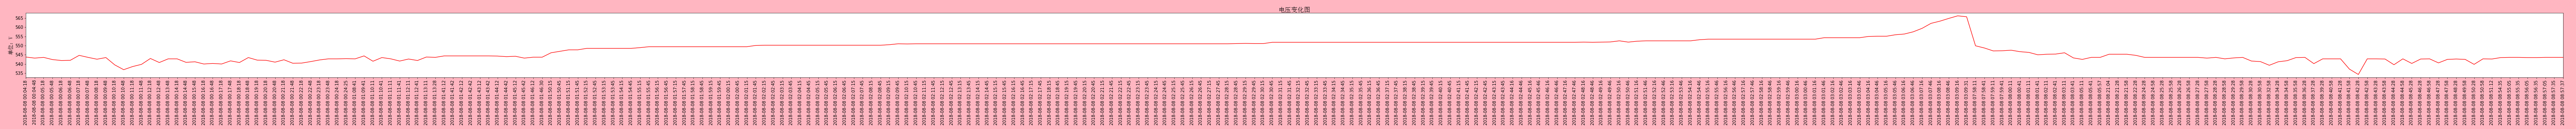

<IPython.core.display.Javascript object>


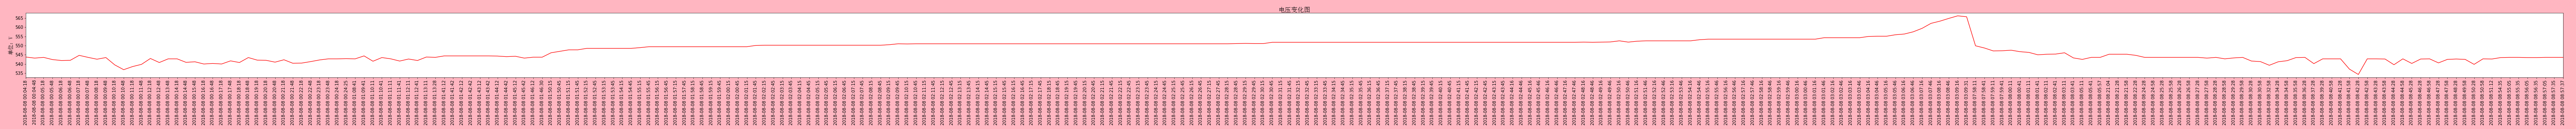

Text(0.5, 1.0, '电压变化图')

(0, 20)

([<matplotlib.axis.XTick at 0x11732c668>,
 <a list of 286 Text xticklabel objects>)

(array([530., 535., 540., 545., 550., 555., 560., 565., 570.]),
 <a list of 9 Text yticklabel objects>)

Text(0, 0.5, '单位：V')

In [10]:
# 电压趋势图
data1=data.toPandas()
data2=pd.DataFrame(data1[['obd_time','voltage']])
data2['voltage']=data2['voltage'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data2['obd_time'] = pd.to_datetime(data2['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data2.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data2.index
_y = data2.values

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('电压变化图',fontproperties=my_font,fontsize=18,pad=1)

plt.plot(range(len(_x)),_y,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：V',fontproperties=my_font,fontsize=15,rotation=90)

plt.savefig("/Users/ppx/Desktop/picture/LEWTEB144HE103899电压变化图.jpg")
plt.show()

In [15]:
# 电流变化图

data3=pd.DataFrame(data1[['obd_time','current']])
data3['current']=data3['current'].astype('double')

# 使用Matplotlib的字体管理器加载中文字体
# my_font=fm.FontProperties(fname="/Users/ppx/Desktop/中文字体/simsun.ttf")

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data3['obd_time'] = pd.to_datetime(data3['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data3.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data3.index
_y = data3.values
_y=_y.reshape(1,-1)[0]
_y
plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('电流变化图',fontproperties=my_font,fontsize=20,pad=10)

plt.plot(range(len(_x)),_y,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：A',fontproperties=my_font,fontsize=15,rotation=90)
plt.grid()
for a,b in zip(_x,_y):
    plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=7)

# plt.savefig("/Users/ppx/Desktop/picture/LEWTEB144HE103899电流变化图.jpg")
plt.show()

NameError: name 'data1' is not defined

<IPython.core.display.Javascript object>


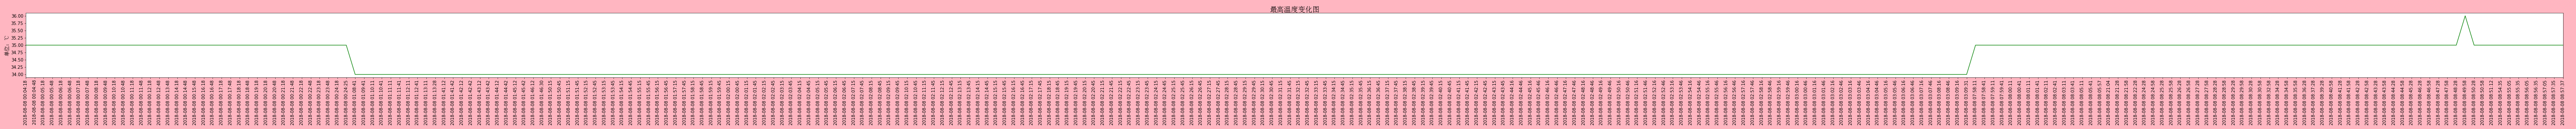

<IPython.core.display.Javascript object>


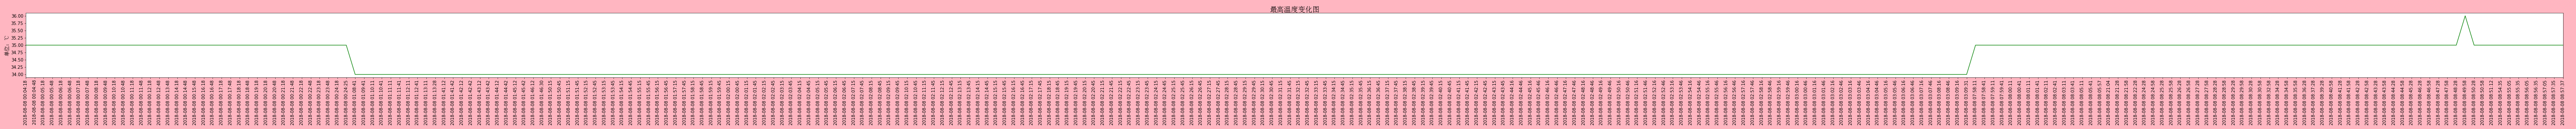

Text(0.5, 1.0, '最高温度变化图')

(0, 20)

([<matplotlib.axis.XTick at 0x12a7accf8>,
 <a list of 286 Text xticklabel objects>)

(array([33.75, 34.  , 34.25, 34.5 , 34.75, 35.  , 35.25, 35.5 , 35.75,
        36.  , 36.25]), <a list of 11 Text yticklabel objects>)

Text(0, 0.5, '单位：℃')

In [18]:
# 最高温度变化图

data4=pd.DataFrame(data1[['obd_time','maximum_temperature_value']])
data4['maximum_temperature_value']=data4['maximum_temperature_value'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data4['obd_time'] = pd.to_datetime(data4['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data4.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data4.index
_y = data4.values

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('最高温度变化图',fontproperties=my_font,fontsize=20,pad=1)

plt.plot(range(len(_x)),_y,color='g')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：℃',fontproperties=my_font,fontsize=15,rotation=90)

plt.savefig("/Users/ppx/Desktop/picture/LEWTEB144HE103899最高温度变化图.jpg")
plt.show()

<IPython.core.display.Javascript object>


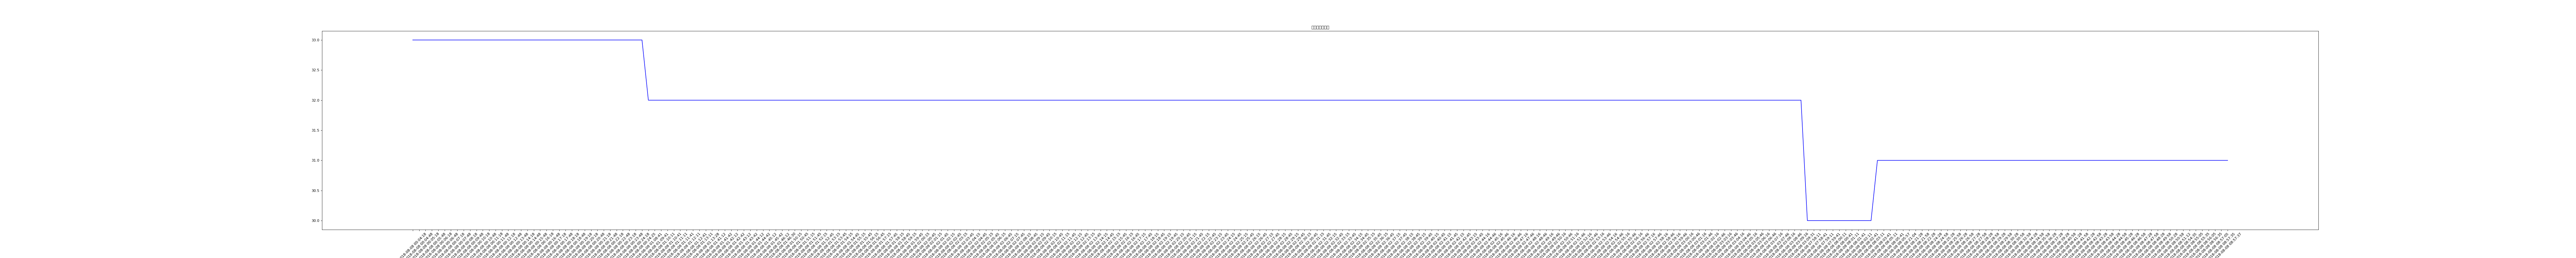

<IPython.core.display.Javascript object>


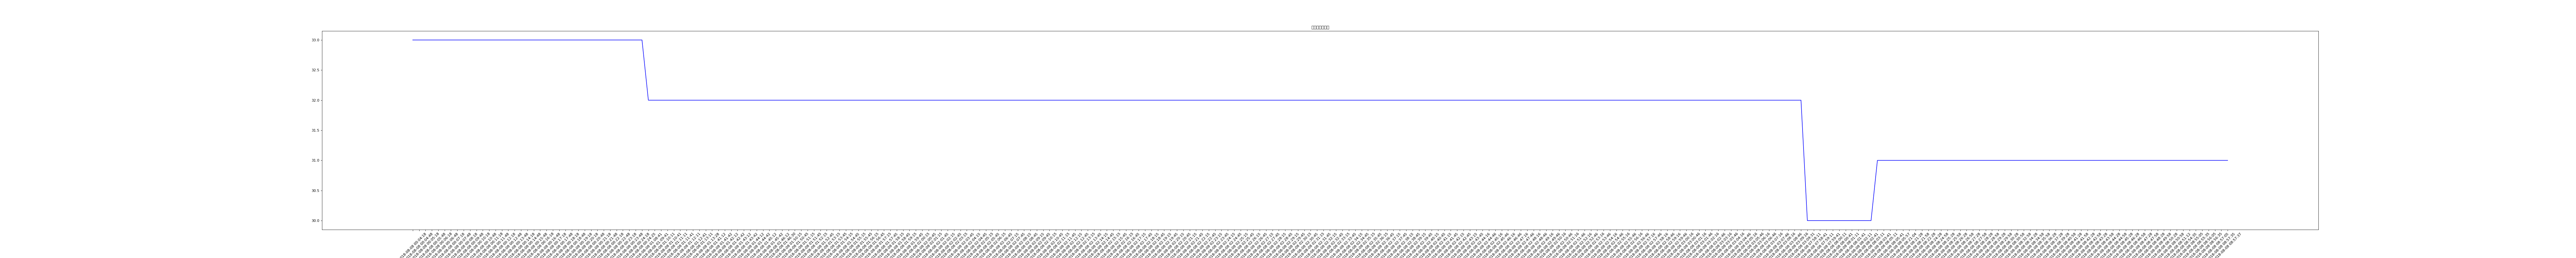

Text(0.5, 1.0, '最低温度变化图')

([<matplotlib.axis.XTick at 0x1513ebe10>,
 <a list of 286 Text xticklabel objects>)

In [94]:
# 最低温度变化图

data5=pd.DataFrame(data1[['obd_time','minimum_temperature_value']])
data5['minimum_temperature_value']=data5['minimum_temperature_value'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data5['obd_time'] = pd.to_datetime(data5['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data5.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data5.index
_y = data5.values

plt.figure(figsize=(100,10),dpi=80)
plt.title('最低温度变化图',fontproperties=my_font,fontsize=20,pad=10)

plt.plot(range(len(_x)),_y,color='b')
# rotation表字体倾斜45度
plt.xticks(range(len(_x)),_x,rotation=45)
plt.show()

In [13]:
import numpy as np
from bqplot import pyplot as plt

plt.figure(1, title='Line Chart')
np.random.seed(0)
n = 200
x = np.linspace(0.0, 10.0, n)
y = np.cumsum(np.random.randn(n))
plt.plot(x, y)
plt.show()

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, scale_x=LinearScale(allow_padding=False,…

Lines(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, x=array([ 0.        ,  0.05025126,  0.10050251,  0.15075377,  0.20100503,
        0.25125628,  0.30150754,  0.35175879,  0.40201005,  0.45226131,
        0.50251256,  0.55276382,  0.60301508,  0.65326633,  0.70351759,
        0.75376884,  0.8040201 ,  0.85427136,  0.90452261,  0.95477387,
        1.00502513,  1.05527638,  1.10552764,  1.15577889,  1.20603015,
        1.25628141,  1.30653266,  1.35678392,  1.40703518,  1.45728643,
        1.50753769,  1.55778894,  1.6080402 ,  1.65829146,  1.70854271,
        1.75879397,  1.80904523,  1.85929648,  1.90954774,  1.95979899,
        2.01005025,  2.0